**ResNet18 without dropout**

In [ ]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F  # Functional module for activation functions and more
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [ ]:
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [ ]:
# Example of using the ResNet18 model
model = ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10)  # 4 blocks with 2 layer each
print(model)


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2):

Using device: cuda:0


In [ ]:
# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# Define the network, loss function, and optimizer
net = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(trainloader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(testloader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Training loss: 1.280644409182128, Validation loss: 1.1355501877994965, Validation Accuracy: 61.59%
Epoch 2, Training loss: 0.7866301239966889, Validation loss: 0.6884597480392304, Validation Accuracy: 75.84%
Epoch 3, Training loss: 0.5912643176904491, Validation loss: 0.5806384980202483, Validation Accuracy: 79.74%
Epoch 4, Training loss: 0.4593221615387397, Validation loss: 0.5827088850660446, Validation Accuracy: 80.64%
Epoch 5, Training loss: 0.3540681484617145, Validation loss: 0.5230654119350278, Validation Accuracy: 82.8%
Epoch 6, Training loss: 0.2588332318441653, Validation loss: 0.5236453376591396, Validation Accuracy: 83.01%
Epoch 7, Training loss: 0.18340458618852376, Validation loss: 0.5164587274907877, Validation Accuracy: 84.35%
Epoch 8, Training loss: 0.13274437200214884, Validation loss: 0.5767607120588755, Validation Accuracy: 83.68%
Epoch 9, Training loss: 0.09936336249736348, Validat

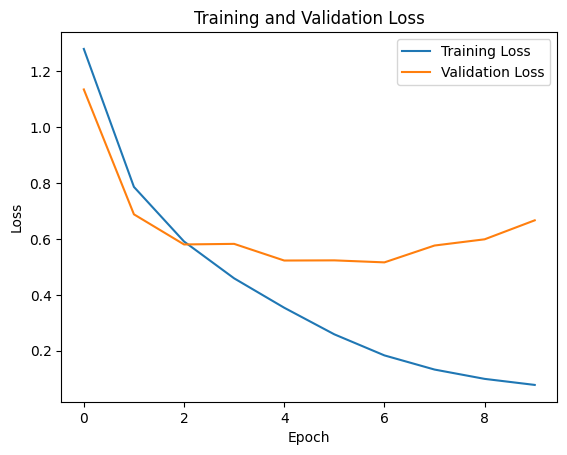

In [ ]:




# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('temp/ResNet_training_validation_loss.png')
plt.show()

In [ ]:
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

**with dropout**

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.5):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        # Optional: Add dropout to BasicBlock if needed
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)  # Applying dropout after first convolution
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [ ]:
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.5):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_rate=dropout_rate)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, dropout_rate):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout_rate))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [ ]:
# Example of using the ResNet18 model
model = ResNet18(BasicBlock, [2, 2, 2, 2], num_classes=10)  # 4 blocks with 2 layer each
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2):

In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [ ]:
# Load and preprocess CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# Define the network, loss function, and optimizer
net = model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Lists for storing loss values and validation accuracy
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

# Training and validation loop
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_list.append(running_loss / len(trainloader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss_list.append(running_loss / len(testloader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]}, Validation loss: {val_loss_list[-1]}, Validation Accuracy: {val_accuracy}%')

# Print final validation accuracy
print(f'Final Validation Accuracy: {val_accuracy_list[-1]}%')
# Calculate total number of parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'Total number of parameters in the model: {total_params}')

100%|██████████| 170498071/170498071 [00:01<00:00, 105711748.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1, Training loss: 1.3287889421253118, Validation loss: 1.0301005328044344, Validation Accuracy: 62.63%
Epoch 2, Training loss: 0.8686184366200875, Validation loss: 0.7708196941846476, Validation Accuracy: 72.58%
Epoch 3, Training loss: 0.6929409017432445, Validation loss: 0.6028816425762238, Validation Accuracy: 79.35%
Epoch 4, Training loss: 0.5824857316410702, Validation loss: 0.5679230806640924, Validation Accuracy: 81.4%
Epoch 5, Training loss: 0.5026537675841909, Validation loss: 0.5005271800409872, Validation Accuracy: 82.95%
Epoch 6, Training loss: 0.43001222883137236, Validation loss: 0.48892309004887224, Validation Accuracy: 83.4%
Epoch 7, Training loss: 0.3721471377198542, Validation loss: 0.4471965149616281, Validation Accuracy: 84.91%
Epoch 8, Training loss: 0.3192064814812963, Validation loss: 0.4884359524034844, Validation Accuracy: 84.36%
Epoch 9, Training loss: 0.2741350024528

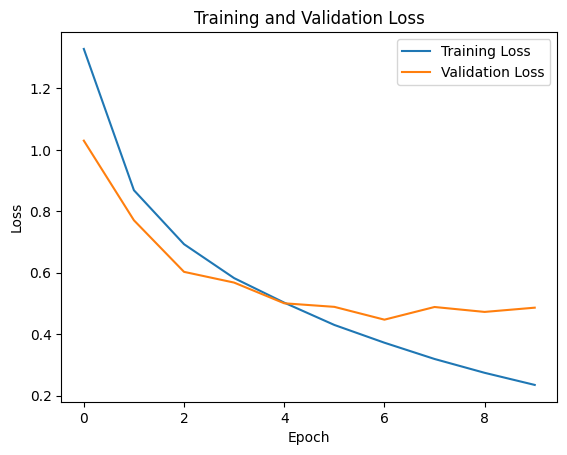

In [ ]:

# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('temp/ResNet_training_validation_loss.png')
plt.show()

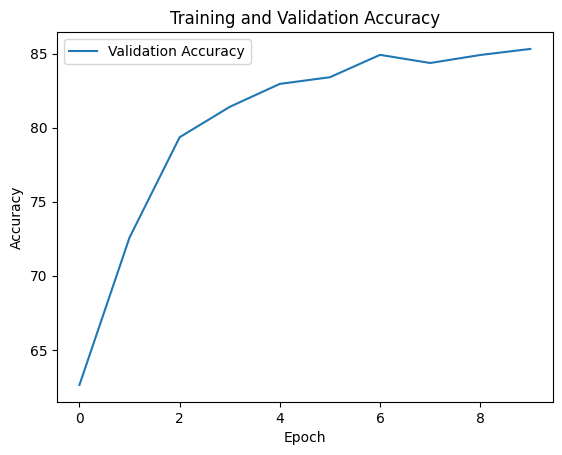

In [ ]:

# plt.plot(train_acc_history, label='Training Accuracy')
plt.plot( val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

